<a href="https://colab.research.google.com/github/Reemaalt/Detection-of-Hallucination-in-Arabic/blob/main/SE_threshold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
# File paths
entropy_file = "semantic_entropy_Llama3.1-8b_xquadAll_results (1).json"
labels_file = "labeled_data_rougel.json"

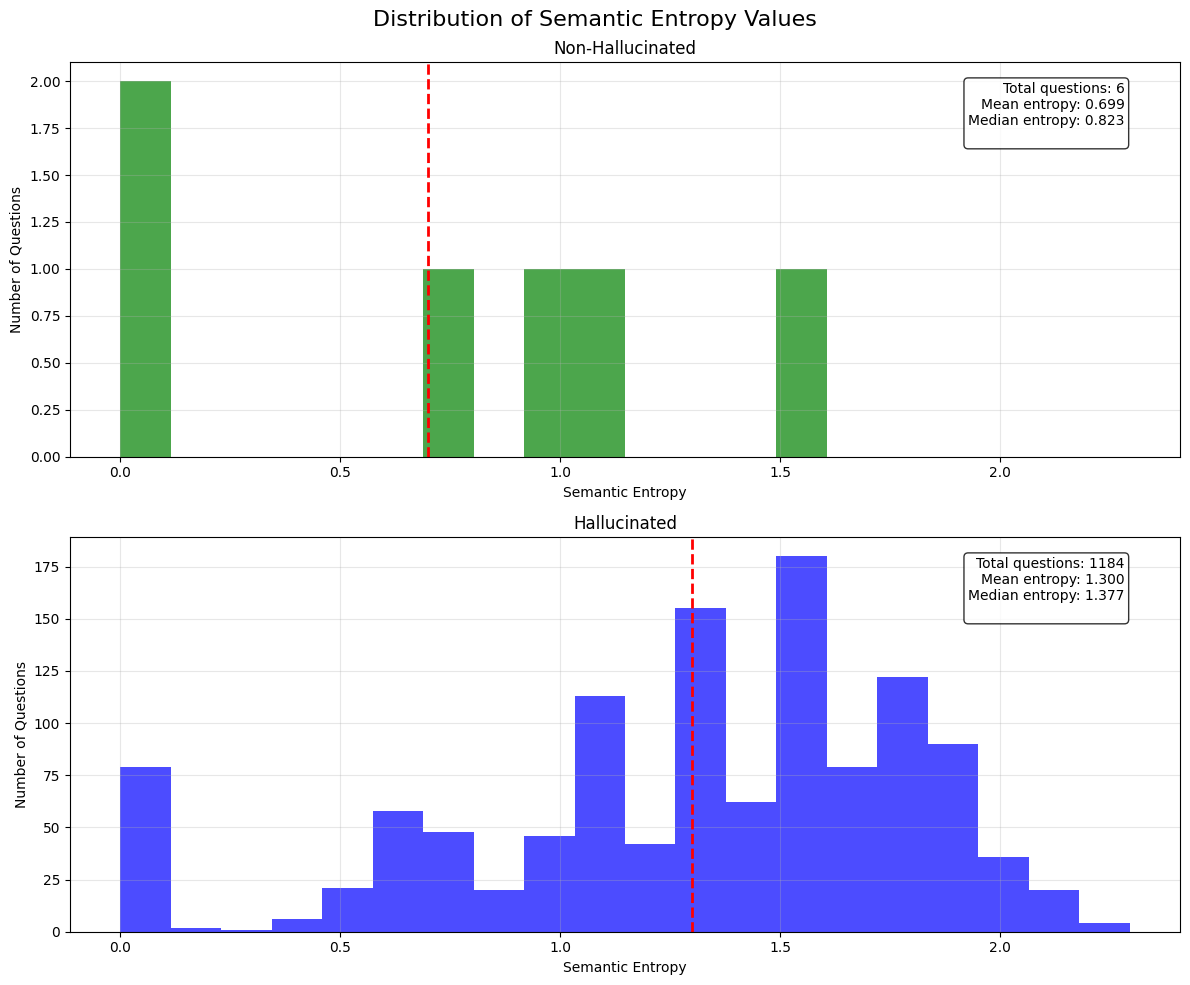

In [65]:
import json
import matplotlib.pyplot as plt
import numpy as np

def load_and_process_data(entropy_file, labels_file):
    # Load files
    with open(entropy_file, 'r', encoding='utf-8') as f:
        entropy_data = json.load(f)

    with open(labels_file, 'r', encoding='utf-8') as f:
        labels_data = json.load(f)

    # entropy values and their labels
    processed_data = {
        'hallucinated': [],
        'non_hallucinated': []
    }

    #match questions and collect entropy values with their labels
    for qid in entropy_data: #quesion-id
        if qid in labels_data:
            entropy_value = entropy_data[qid]['semantic_entropy']
            question_label = labels_data[qid]['question_label']

            if question_label == 'Hallucinated':
                processed_data['hallucinated'].append(entropy_value)
            else:
                processed_data['non_hallucinated'].append(entropy_value)

    return processed_data

def stats_box(ax, values, title):
    stats_text = (
        f"Total questions: {len(values)}\n"
        f"Mean entropy: {np.mean(values):.3f}\n"
        f"Median entropy: {np.median(values):.3f}\n"
        #f"Standard deviation: {np.std(values):.3f}"
    )
    # Placement
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    ax.text(0.95, 0.95, stats_text,
            transform=ax.transAxes,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=props,
            fontsize=10)
    # Add vertical lines for mean and median
    ax.axvline(np.mean(values), color='red', linestyle='dashed', linewidth=2, label=f"Mean: {np.mean(values):.3f}")

def plot_entropy_distributions(data):
    hallucinated_values = np.array(data['hallucinated'])
    non_hall_values = np.array(data['non_hallucinated'])

    # Find the global min and max for consistent binning
    min_entropy = min(np.min(hallucinated_values), np.min(non_hall_values))
    max_entropy = max(np.max(hallucinated_values), np.max(non_hall_values))

    # Create 20 bins across the actual range of the data
    bins = np.linspace(min_entropy, max_entropy, 21)

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    fig.suptitle('Distribution of Semantic Entropy Values', fontsize=16)

    # Plot non-hallucinated distribution
    n1, bins1, patches1 = ax1.hist(non_hall_values, bins=bins, color='green', alpha=0.7)

    ax1.set_title('Non-Hallucinated')
    ax1.set_xlabel('Semantic Entropy')
    ax1.set_ylabel('Number of Questions')
    ax1.grid(True, alpha=0.3)
    stats_box(ax1, non_hall_values, "Non-hallucinated answers")

    # Plot hallucinated distribution
    n2, bins2, patches2 = ax2.hist(hallucinated_values, bins=bins, color='blue', alpha=0.7)

    ax2.set_title('Hallucinated')
    ax2.set_xlabel('Semantic Entropy')
    ax2.set_ylabel('Number of Questions')
    ax2.grid(True, alpha=0.3)
    stats_box(ax2, hallucinated_values, "Hallucinated answers")

    plt.tight_layout()
    plt.show()

data = load_and_process_data(entropy_file, labels_file)
# Create visualization
plot_entropy_distributions(data)

In [44]:
from sklearn.cluster import KMeans

def compute_kmeans_threshold(entropy_values):
    entropy_values = np.array(entropy_values).reshape(-1, 1)
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    kmeans.fit(entropy_values)
    cluster_centers = sorted(kmeans.cluster_centers_.flatten())
    return cluster_centers[1]

entropy_values = np.array(data['hallucinated'] + data['non_hallucinated'])
threshold = compute_kmeans_threshold(entropy_values)

print(f"K-Means Clustering SE Threshold: {threshold:.5f}")

K-Means Clustering SE Threshold: 1.60625


In [57]:
output_file = "labeled_data_semantic_entropy.json"
import json

def hallucination_labels(entropy_file, threshold):
    with open(entropy_file, 'r', encoding='utf-8') as f:
        data = json.load(f)

    for qid in data:
        entropy = data[qid]['semantic_entropy']
        if entropy > threshold:
            data[qid]['question_label_SE'] = 'hallucinated'
        else:
            data[qid]['question_label_SE'] = 'non-hallucinated'

    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(data, f, indent=4)
    print(f"Successfully added hallucination labels to '{output_file}'")

hallucination_labels(entropy_file, threshold)

Successfully added hallucination labels to 'labeled_data_semantic_entropy.json'


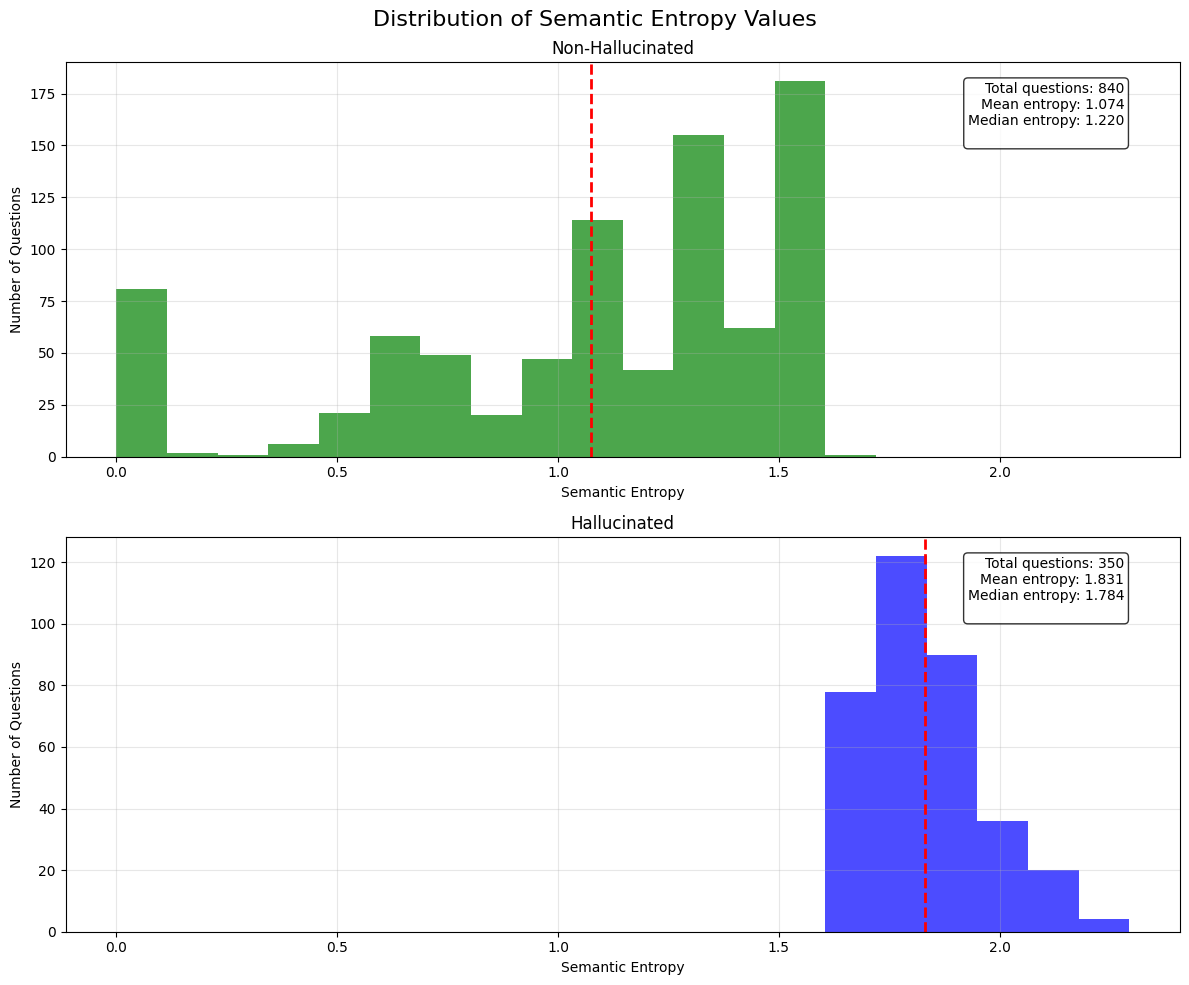

In [66]:
def load_and_process_data2(entropy_labeled_file):
    # Load files
    with open(entropy_labeled_file, 'r', encoding='utf-8') as f:
        entropy_labeled_data = json.load(f) # Load the json file

    with open(labels_file, 'r', encoding='utf-8') as f:
        labels_data = json.load(f)

    # entropy values and their labels
    processed_data = {
        'hallucinated': [],
        'non_hallucinated': []
    }

    # Match questions and collect entropy values with their labels
    for qid in entropy_labeled_data: #quesion-id, iterate through the loaded json data
      entropy_value = entropy_labeled_data[qid]['semantic_entropy']
      question_label = entropy_labeled_data[qid]['question_label_SE']

      if question_label == 'hallucinated': # Check for lower case 'hallucinated'
          processed_data['hallucinated'].append(entropy_value)
      else:
          processed_data['non_hallucinated'].append(entropy_value)

    return processed_data

entropy_labeled_file = "labeled_data_semantic_entropy.json"
data=load_and_process_data2(entropy_labeled_file)
# Create visualization
plot_entropy_distributions(data)